## In this notebook I will illustrate how PCA can be computed and how much information lies in the different coefficients

About PCA:
- PCA garantees output vectors that are un-correlated with each other
- SVD automatically outputs the sorted eigenvectors (principal components)
- We remove the mean to make sure that the offset does not get interpreted as a direction of variance

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

s = np.load('../test_data_sintef.npy')

# PCA

In [27]:
# Find the principal components using three different methods and compare 

temp = s[:500,:].astype(int)

# Normalize the data: 
mean = np.mean(temp, axis=0)

mean_temp = temp - mean

# find PCA using eigenvalues (built with the help of: https://towardsdatascience.com/a-step-by-step-implementation-of-principal-component-analysis-5520cc6cd598)
cov = np.cov(mean_temp.T)
eig_val, eig_vec = np.linalg.eig(cov)

# sort eigenvalues
indices = np.arange(0,len(eig_val),1)
indices = ([x for _,x in sorted(zip(eig_val, indices))])[::-1]
eig_val = eig_val[indices]
eig_vec = eig_vec[:,indices]

pca_temp_1 = mean_temp@eig_vec


# find PCA using SVD
U,sigma,V = np.linalg.svd(mean_temp.T@mean_temp)
np.allclose(V.T, U) # this should be true, if not something is incorrect
pca_temp_2 = mean_temp@U



# find PCA using library
pca = PCA()
pca_temp_3 = pca.fit_transform(temp)

# compare resulting coefficients on three coefficients
print(f'Method 1 gives same as method 2: {np.allclose(np.abs(pca_temp_1), np.abs(pca_temp_2))}')
print(f'Method 1 gives same as method 3: {np.allclose(np.abs(pca_temp_1), np.abs(pca_temp_3))}')

Method 1 gives same as method 2: True
Method 1 gives same as method 3: True


We see that all methods give the same result. Next we check how much each principal components contributes

explained variance: 
[0.39915587 0.2454873  0.11401362 0.08079757 0.04374768 0.02732161
 0.01494193 0.01185748 0.01090962 0.0098645  0.0085061  0.00742084
 0.00698536 0.00665654 0.00651502 0.00581893] 

cumulative variance: 
[0.39915587 0.64464317 0.75865679 0.83945436 0.88320205 0.91052366
 0.92546559 0.93732308 0.9482327  0.9580972  0.9666033  0.97402415
 0.9810095  0.98766605 0.99418107 1.        ] 



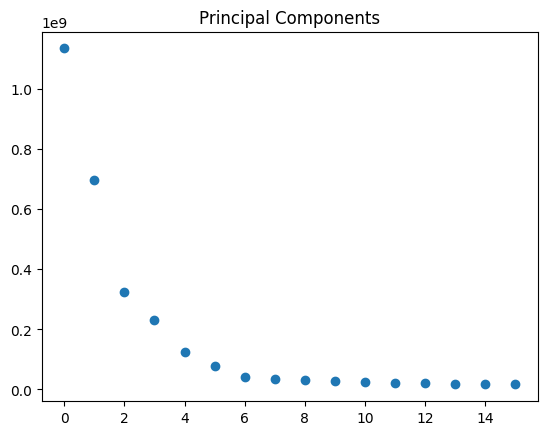

In [28]:
# Display contribution of each singular value

sum_sigma = np.sum(sigma)
explained_variance = sigma/ sum_sigma
print(f'explained variance: \n{explained_variance} \n')
cumulative_variance = np.cumsum(explained_variance)
print(f'cumulative variance: \n{cumulative_variance} \n')

plt.title('Principal Components')
plt.scatter(np.arange(0,len(sigma)),sigma)

The results indicate that the PCA does not compress particularly well, since we need 10 of 16 coefficients to maintain 95% of the variance. Next we se how well we can reconstruct the signal without these six coefficients

SNDR: 11.96 dB 



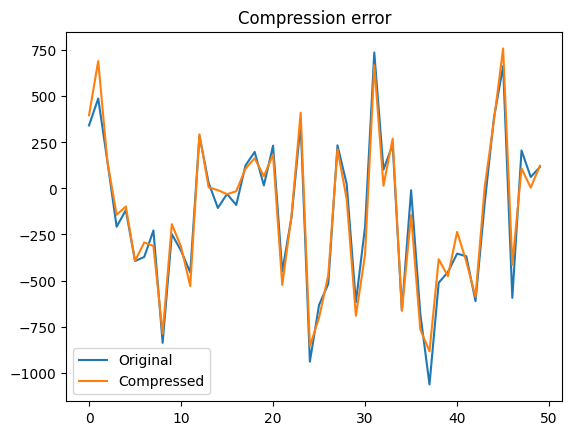

In [31]:
# remove coefficients and reconstruct the signal:
n_remove = 6

# compute PCA and remove n_remove coefficients
pca_th = np.pad(mean_temp@U[:,:-n_remove], ((0,0), (0,n_remove)), 'constant', constant_values=(0))

# re-construct signal
temp_hat = pca_th@U.T + mean

# plot result and display SNDR
plt.title('Compression error')
plt.plot(temp[:50,0])
plt.plot(temp_hat[:50,0])
plt.legend(['Original', 'Compressed'])

SNDR = 0
for i in range(temp.shape[1]):
    SNDR += 1/(temp.shape[1]) * 20*np.log10(np.linalg.norm(temp[:,i])/np.linalg.norm(temp[:,i] - temp_hat[:,i]))


print(f'SNDR: {SNDR:.2f} dB \n')

This indicates that the channels are not particularly correlated, if we compute the PCA on only the tetrode channels we get the following results:

explained variance: 
[0.42258149 0.29778246 0.05545045 0.03619654 0.03362738 0.03014262
 0.0255747  0.02182578 0.02111957 0.01954323 0.01948524 0.01667055] 

cumulative variance: 
[0.42258149 0.72036395 0.7758144  0.81201094 0.84563832 0.87578093
 0.90135564 0.92318141 0.94430098 0.96384421 0.98332945 1.        ] 

SNDR: 8.03 dB 



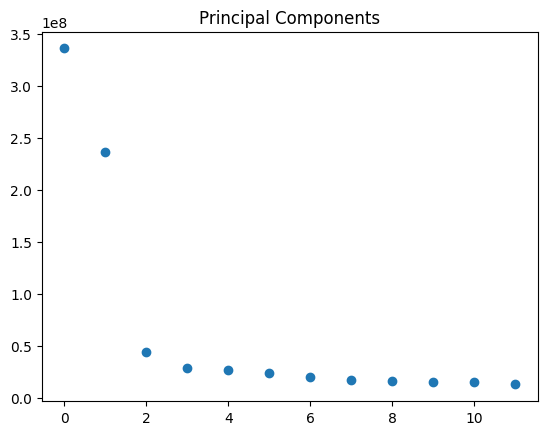

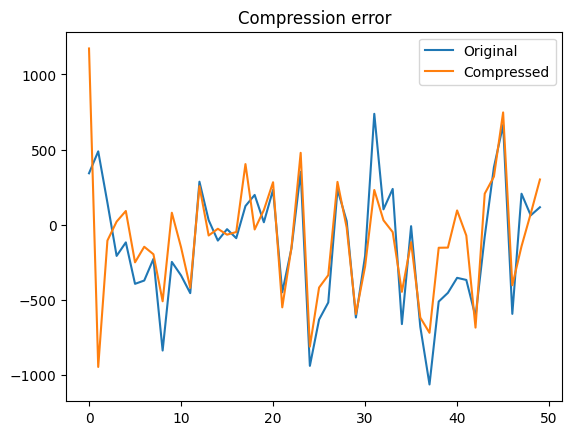

In [32]:
# Find the principal components using three different methods and compare 

temp = s[:400,:12].astype(int)

# Normalize the data: 
mean = np.mean(temp, axis=0)

mean_temp = temp - mean

# find PCA using SVD
U,sigma,V = np.linalg.svd(mean_temp.T@mean_temp)
np.allclose(V.T, U) # this should be true, if not something is incorrect
pca_temp_2 = mean_temp@U


sum_sigma = np.sum(sigma)
explained_variance = sigma/ sum_sigma
print(f'explained variance: \n{explained_variance} \n')
cumulative_variance = np.cumsum(explained_variance)
print(f'cumulative variance: \n{cumulative_variance} \n')

plt.title('Principal Components')
plt.scatter(np.arange(0,len(sigma)),sigma)

# remove coefficients and reconstruct the signal:
n_remove = temp.shape[1] - 2

# compute PCA and remove n_remove coefficients
pca_th = np.pad(mean_temp@U[:,:-n_remove], ((0,0), (0,n_remove)), 'constant', constant_values=(0))

# re-construct signal
temp_hat = pca_th@U.T + mean

# plot result and display SNDR
plt.figure()
plt.title('Compression error')
plt.plot(temp[:50,0])
plt.plot(temp_hat[:50,0])
plt.legend(['Original', 'Compressed'])

SNDR = 0
for i in range(temp.shape[1]):
    SNDR += 1/(temp.shape[1]) * 20*np.log10(np.linalg.norm(temp[:,i])/np.linalg.norm(temp[:,i] - temp_hat[:,i]))
print(f'SNDR: {SNDR:.2f} dB \n')

Here we can see a clear elbow after two coefficients, so we can get decent reconstuction using only two coefficients. But this error is most likely more then what the researchers would like